# How to make a heatmap using BigQuery 
Purpose: Demonstrate how to make a correlation matrix and create a heatmap visualization.<br>
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_make_a_heatmap_using_BigQuery.ipynb

このノートブックでは、BigQuery を使用してデータを取得し、相関マトリックスを作成し、結果をヒートマップで可視化していきます。<br>
BigQuery 内で相関関係を計算することもできますが、今回は Python を使用して計算を行います。

今回はがんデータ分析を行いますが、相関分析はあらゆるデータで活用できる分析方法です。<br>
ここではKIRC（腎臓癌）とGBM（脳癌）の2つの研究から得られたTCGA遺伝子発現データを用い、<br>
2つの組織タイプがクラスターに分かれるかどうかを検証します。。

ISB-CGC BigQueryテーブル検索ツールを使って、GCPプロジェクトを作成する前に、利用可能なテーブルやデータセットを調べることもできます。

[ISB-CGC BigQueryテーブル検索ツール](https://isb-cgc.appspot.com/bq_meta_search/)

In [51]:
!pip install --upgrade seaborn
!pip install --upgrade scipy

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.10/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
 

In [1]:
import seaborn as sb
import scipy
import pandas as pd
import numpy as np
from google.cloud import bigquery
client = bigquery.Client()
%load_ext google.cloud.bigquery

#### テーブルのスキーマを確認する

BigQuery のInformation Schema には、データセットのメタデータが格納されており、クエリで取得することができます。<br>
今回使用する 'TCGA_hg19_data_v0' テーブルのスキーマとその説明を取得してみましょう。

In [2]:
%%bigquery
SELECT column_name, description
FROM `isb-cgc.TCGA_hg19_data_v0.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS`
WHERE table_name = 'RNAseq_Gene_Expression_UNC_RSEM'

/home/user/.local/lib/python3.10/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/home/user/.local/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,column_name,description
0,project_short_name,Project name abbreviation; the program name ap...
1,case_barcode,"Original TCGA case barcode, eg TCGA-12-1089 -..."
2,sample_barcode,"Original TCGA sample barcode, eg TCGA-12-1089-01A"
3,aliquot_barcode,"Original TCGA aliquot barcode, eg TCGA-12-1089..."
4,HGNC_gene_symbol,"HUGO Gene Nomenclature Committee gene symbol, ..."
5,gene_id,"The gene symbol. In this table, gene symbol is..."
6,normalized_count,Normalized gene expression from original rsem....
7,original_gene_symbol,"Gene symbol from the original data file, diffe..."
8,platform,Platform used to generate data; either Illumin...


このように 8つのスキーマがあります。<br>

#### 特定のスキーマを集計する
'TCGA Study Nameの略称（project_short_name）'について集計をしてみましょう

In [3]:
%%bigquery
SELECT project_short_name, 
COUNT(*) AS n 
FROM `isb-cgc.TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM` 
GROUP BY project_short_name 
ORDER BY n DESC

/home/user/.local/lib/python3.10/site-packages/google/cloud/bigquery/job/query.py:1859: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  query_result = wait_for_query(self, progress_bar_type, max_results=max_results)
/home/user/.local/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2153: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,project_short_name,n
0,TCGA-BRCA,24945165
1,TCGA-KIRC,12441786
2,TCGA-UCEC,11949042
3,TCGA-LUAD,11825856
4,TCGA-THCA,11743732
5,TCGA-HNSC,11620546
6,TCGA-LUSC,11353643
7,TCGA-PRAD,11292050
8,TCGA-LGG,10963554
9,TCGA-COAD,10676120


このように、簡単なSQL を用いて集計をすることができます

#### BigQuery へクエリを実行する
まずは MSigDB から登録されている遺伝子セットの情報をダウンロードし、リストとして抽出します

In [22]:
!curl -o geneset.txt https://www.gsea-msigdb.org/gsea/msigdb/download_geneset.jsp?geneSetName=HALLMARK_TGF_BETA_SIGNALING

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   436  100   436    0     0    660      0 --:--:-- --:--:-- --:--:--   659


In [4]:
genes = open('geneset.txt','r').read().strip().split('\n')
genes = ["'"+x+"'" for x in genes]
### Make the set a little smaller ###
genelist = ' ' + ','.join(genes[2:12]) + ' '  
genelist

" 'ACVR1','APC','ARID4B','BCAR3','BMP2','BMPR1A','BMPR2','CDH1','CDK9','CDKN1C' "

BigQuery へ以下の条件でクエリを実行します
- Project Short Name が KIRC（腎臓癌）とGBM（脳癌）であるデータを抽出
- さらにその中で、HUGO Gene Nomenclature Committee gene symbol がダウンロードしたリストに含まれているデータのみ抽出

replace を用いて、SQL のWHERE句内に Python で定義したList を使用しています。<br>

In [5]:
sql = '''
SELECT project_short_name, sample_barcode, HGNC_gene_symbol, normalized_count 
FROM `isb-cgc.TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM`
WHERE project_short_name IN ('TCGA-KIRC', 'TCGA-GBM')
AND HGNC_gene_symbol IN (__GENELIST__) 
GROUP BY 1,2,3,4
'''.replace('__GENELIST__', genelist)

In [6]:
df = client.query(sql).to_dataframe() 

In [7]:
df[0:10]

,project_short_name,sample_barcode,HGNC_gene_symbol,normalized_count
0,TCGA-KIRC,TCGA-BP-4343-01A,CDK9,625.7217
1,TCGA-KIRC,TCGA-EU-5905-01A,CDKN1C,315.5105
2,TCGA-GBM,TCGA-06-0675-11A,BCAR3,340.0825
3,TCGA-KIRC,TCGA-B0-5691-11A,CDK9,700.9401
4,TCGA-KIRC,TCGA-BP-4353-01A,ARID4B,1367.1083
5,TCGA-KIRC,TCGA-A3-3329-01A,CDK9,1002.7922
6,TCGA-KIRC,TCGA-CJ-4870-01A,BMPR2,3003.1917
7,TCGA-KIRC,TCGA-CJ-5680-11A,APC,1249.9124
8,TCGA-KIRC,TCGA-BP-5201-01A,APC,932.8155
9,TCGA-GBM,TCGA-14-0781-01B,ACVR1,917.2038


***クエリ実行前に発生する課金を調べたい時***

以下のように Query Config を設定することで、クエリ実行時に何Byte の処理が実行されるかを確認することができます

In [8]:
job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
query_job = client.query(
    sql,
    job_config=job_config,
)

print("This query will process {} GB.".format(query_job.total_bytes_processed/1024/1024/1024))

This query will process 9.419036312028766 GB.


#### データを行列に変換し、相関行列を計算する

In [9]:
mat = pd.pivot_table(df, values='normalized_count', columns='HGNC_gene_symbol', index ='sample_barcode')

In [10]:
mat.shape

(779, 10)

In [11]:
mat

HGNC_gene_symbol,ACVR1,APC,ARID4B,BCAR3,BMP2,BMPR1A,BMPR2,CDH1,CDK9,CDKN1C
sample_barcode,,,,,,,,,,
TCGA-02-0047-01A,988.9671,3388.5491,687.1754,122.3148,287.0402,902.9165,2020.3448,264.9129,953.9322,268.6008
TCGA-02-0055-01A,1309.0399,682.8311,630.1331,1500.7708,986.1247,423.2656,1218.7807,2.2425,1166.0827,227.0498
TCGA-02-2483-01A,603.2718,1136.0422,884.8549,134.2480,286.6491,622.2691,1446.7546,18.9974,1939.4195,274.4063
TCGA-02-2485-01A,801.4286,2498.5714,711.3476,624.2857,193.8095,393.8095,1628.0952,112.3810,1120.0000,117.1429
TCGA-02-2486-01A,693.2927,1295.7317,508.5366,270.1220,198.7805,351.8293,1331.0976,9.1463,1351.2195,312.8049
...,...,...,...,...,...,...,...,...,...,...
TCGA-MM-A563-01A,773.8693,628.1407,1035.1759,672.3065,329.1457,359.2965,2379.3970,1807.0352,1117.5879,1627.1357
TCGA-MM-A564-01A,607.1653,574.4815,1616.5933,472.5393,150.8485,357.6367,2565.0534,113.1364,1762.4136,817.7247
TCGA-MM-A84U-01A,842.8169,450.7042,816.3380,243.9437,299.1549,313.2394,2501.4085,1999.4366,1264.2254,544.7887


処理時間の短縮とプロットを見やすくするために、barcode をサンプリングします

In [12]:
idx = np.random.choice(a=range(0,693), size=60, replace=False)
matSample = mat.iloc[idx]
matSample.shape

(60, 10)

相関行列を計算し、ヒートマップで可視化をします

.corr()　を用いると、各行の相関係数が計算されます

In [13]:
cormat = matSample.transpose().corr()
print(cormat.shape)
cormat

(60, 60)


sample_barcode,TCGA-28-5216-01A,TCGA-28-5204-01A,TCGA-CJ-5682-01A,TCGA-BP-4163-01A,TCGA-14-1829-01A,TCGA-06-0211-01A,TCGA-B4-5843-01A,TCGA-A3-3380-01A,TCGA-CJ-4884-01A,TCGA-B0-5109-01A,...,TCGA-BP-4352-01A,TCGA-CJ-5676-01A,TCGA-B0-5095-01A,TCGA-BP-4987-01A,TCGA-BP-4962-01A,TCGA-BP-4355-01A,TCGA-B0-5707-01A,TCGA-06-5416-01A,TCGA-CW-6090-01A,TCGA-CJ-4889-01A
sample_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-28-5216-01A,1.000000,0.910265,0.125075,0.341262,0.878459,0.925282,0.259140,0.100063,0.245714,-0.248869,...,0.160158,-0.003834,0.457946,0.142961,0.190973,0.382572,-0.200192,0.976581,0.349336,0.275898
TCGA-28-5204-01A,0.910265,1.000000,0.334940,0.542217,0.934165,0.973460,0.509489,0.253397,0.449668,-0.284804,...,0.366850,0.084014,0.714741,0.324516,0.421935,0.654706,-0.134846,0.854892,0.562120,0.511467
TCGA-CJ-5682-01A,0.125075,0.334940,1.000000,0.948566,0.302161,0.299690,0.945596,0.908272,0.943576,0.529016,...,0.269251,0.840937,0.826175,0.956579,0.980498,0.689165,0.740147,0.045618,0.600751,0.966878
TCGA-BP-4163-01A,0.341262,0.542217,0.948566,1.000000,0.480441,0.485229,0.945882,0.890358,0.913394,0.386101,...,0.415500,0.814126,0.893331,0.927732,0.979344,0.766774,0.661340,0.237703,0.657703,0.975178
TCGA-14-1829-01A,0.878459,0.934165,0.302161,0.480441,1.000000,0.903365,0.477985,0.188381,0.403454,-0.302956,...,0.210108,-0.016798,0.675833,0.220966,0.357325,0.607467,-0.245321,0.854119,0.567459,0.448270
TCGA-06-0211-01A,0.925282,0.973460,0.299690,0.485229,0.903365,1.000000,0.426128,0.181002,0.463238,-0.252957,...,0.332662,0.088156,0.653848,0.302943,0.380401,0.571205,-0.108268,0.896342,0.518128,0.457820
TCGA-B4-5843-01A,0.259140,0.509489,0.945596,0.945882,0.477985,0.426128,1.000000,0.863910,0.896040,0.373862,...,0.334445,0.672011,0.930550,0.883968,0.940206,0.834566,0.520651,0.152150,0.690611,0.982528
TCGA-A3-3380-01A,0.100063,0.253397,0.908272,0.890358,0.188381,0.181002,0.863910,1.000000,0.775304,0.671076,...,0.353909,0.883225,0.690484,0.882885,0.908106,0.663434,0.792453,-0.020677,0.447733,0.870191
TCGA-CJ-4884-01A,0.245714,0.449668,0.943576,0.913394,0.403454,0.463238,0.896040,0.775304,1.000000,0.462708,...,0.373594,0.762533,0.878445,0.910513,0.940834,0.732145,0.648754,0.173985,0.672490,0.950558


<Axes: xlabel='sample_barcode', ylabel='sample_barcode'>

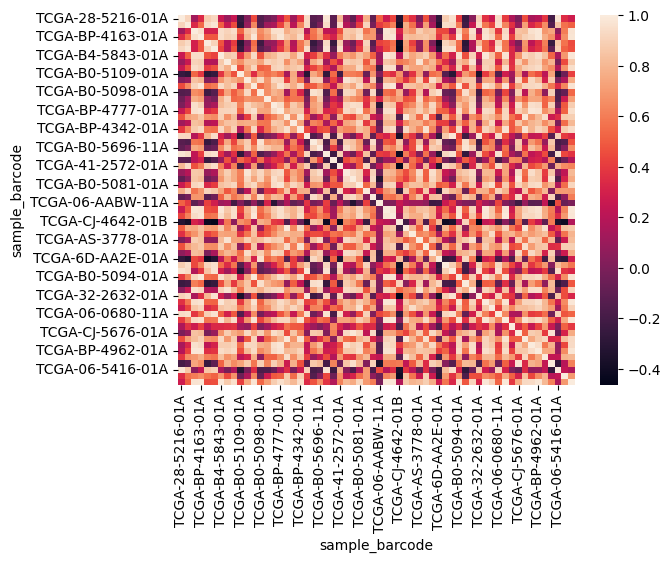

In [14]:
sb.heatmap(cormat, annot=False, )

In [15]:
# first we're getting a unique map of sample barcodes to tissue types
udat = df.loc[:, ['sample_barcode', 'project_short_name']].drop_duplicates()

# then we can get the tissue designations for each random sample in our table
tissueType = udat.loc[ udat['sample_barcode'].isin(matSample.index), ['sample_barcode','project_short_name'] ]

# for use as a color bar in the heatmap, we index the table by barcode
tissueType.index = tissueType['sample_barcode']

In [16]:
# to create the color bar, indicating the sample sources,
# we're going to create a data frame indexed by sample barcode
# and mark KIRC as red and GBM as blue
lut = {'TCGA-KIRC' : 'r', 'TCGA-GBM': 'b'}
row_colors = tissueType['project_short_name'].map(lut)

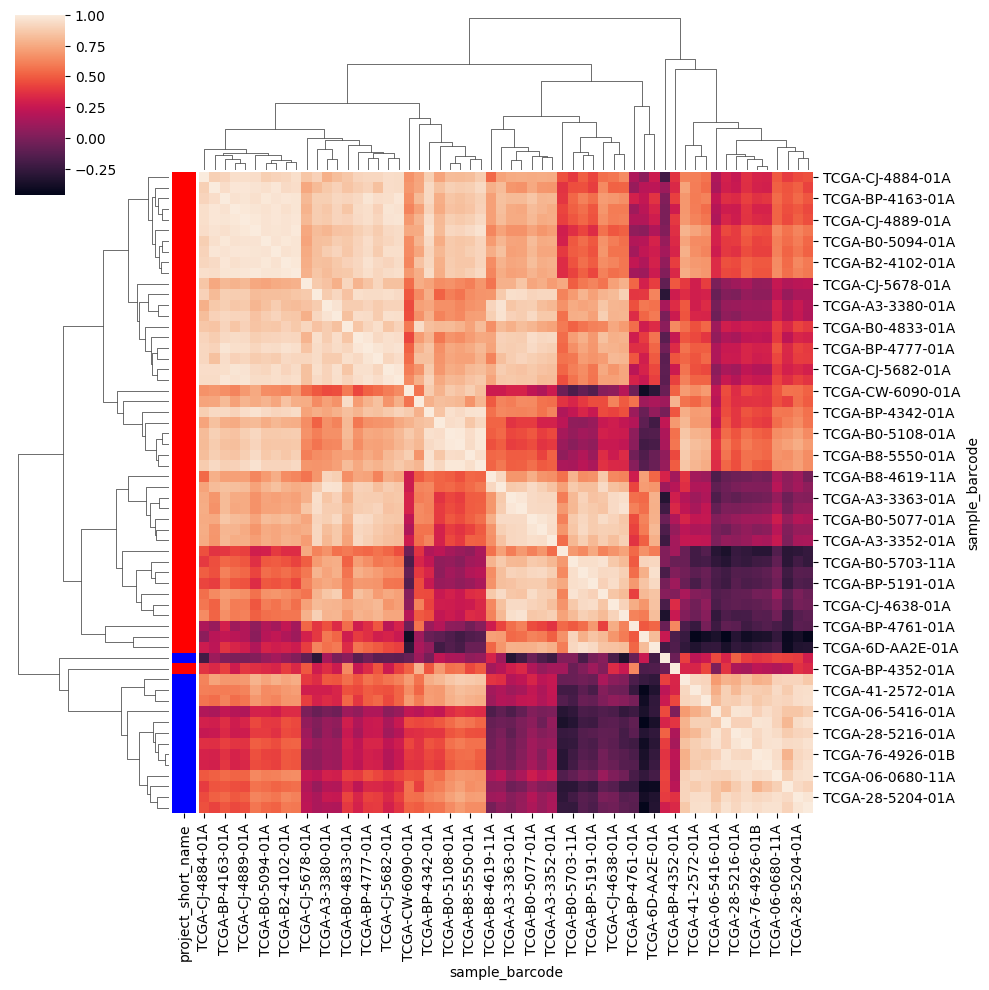

In [17]:
plt = sb.clustermap(cormat, row_colors=row_colors)